In [3]:
import re
import numpy as np
import pandas as pd


In [11]:
ARR_COLS = [
    "TOT_DISCWODIS_ARR_M",
    "TOT_DISCWODIS_ARR_F",
    "TOT_DISCWDIS_ARR_IDEA_M",
    "TOT_DISCWDIS_ARR_IDEA_F",
]

ENR_COLS = ["TOT_ENR_M", "TOT_ENR_F"]

USE_COLS = ARR_COLS + ENR_COLS


read_file = (
    lambda x: pd.read_csv(x, encoding="latin-1", low_memory=False)
    if x.endswith(".csv") or x.endswith(".csv.gz")
    else pd.read_excel(x)
)


def select_cols(df: pd.DataFrame) -> pd.DataFrame:
    """selects columns from the dataframe"""
    return df.set_index("COMBOKEY")[USE_COLS]


def drop_reserve_codes(df: pd.DataFrame) -> pd.DataFrame:
    """drops reserve codes from the dataframe"""
    return df.mask(df.lt(0))


def preprocess_df(df: pd.DataFrame, year) -> pd.DataFrame:
    """preprocesses the dataframe"""
    return df.pipe(select_cols).pipe(drop_reserve_codes).assign(year=year)


def read_segmented_dfs(*filenames) -> pd.DataFrame:
    """reads and stacks the dataframes"""
    return preprocess_df(
        pd.DataFrame()
        .join(
            [
                read_file(f)
                .set_index("COMBOKEY")
                .drop(
                    [
                        "LEA_STATE",
                        "LEA_STATE_NAME",
                        "LEAID",
                        "LEA_NAME",
                        "SCHID",
                        "SCH_NAME",
                        "JJ",
                    ],
                    axis=1,
                    errors="ignore"
                )
                for f in filenames
            ],
            how="outer",
        )
        .reset_index(),
        get_school_year(filenames[0]),
    )


def get_school_year(school_year: str) -> int:
    """gets the year from the school year"""
    school_match = re.search(r"\d{4}-\d{2}", school_year)
    if school_match:
        return int(school_match.group()[:4])

    school_match = re.search(r"\d{4}", school_year)
    if school_match:
        return int("20" + school_match.group()[:2])

    raise ValueError(f"couldn't extract school year from {school_year}")


def read_stack_dfs(*filenames) -> pd.DataFrame:
    """reads and stacks the dataframes"""
    dfs = []
    for filename in filenames:

        match filename:
            case str():
                dfs.append(
                    preprocess_df(
                        read_file(filename),
                        get_school_year(filename),
                    )
                )

            case tuple() | list():
                dfs.append(read_segmented_dfs(*filename))

            case other:
                raise ValueError(f"unknown filename type {type(filename)}")

    return pd.concat(dfs)


df = read_stack_dfs(
    ("input/1718-crdc-sch-referrals-arrests.csv", "input/1718-crdc-sch-enrollment.csv"),
    "input/CRDC-2015-16-School-Data.csv.gz",
    ("input/1314-crdc-sch-referrals-arrests.xlsx", "input/1314-crdc-sch-enrollment.xlsx"),
)


<AxesSubplot:title={'center':'Arrests per 1,000 children'}, xlabel='year'>

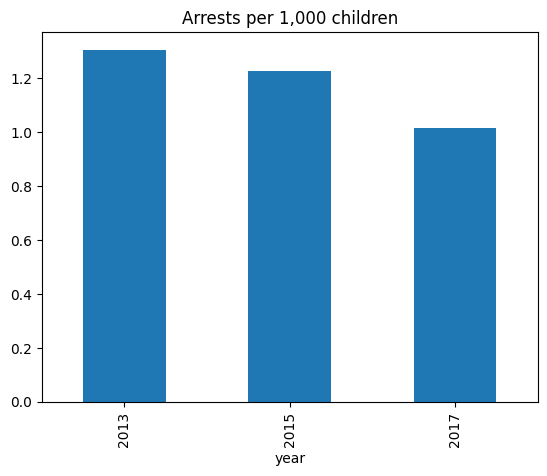

In [22]:
(
    df.assign(
        total_arrests=df[ARR_COLS].sum(axis=1),
        total_enrollment=df[ENR_COLS].sum(axis=1),
    )
    .groupby("year")[["total_arrests", "total_enrollment"]]
    .sum()
    .assign(arrest_rate=lambda df: df.total_arrests / df.total_enrollment)
    .arrest_rate.multiply(1000).plot(kind="bar", title="Arrests per 1,000 children")
)
